In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as utils

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3 + 1, 2) * 0.2 # Add one sample
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

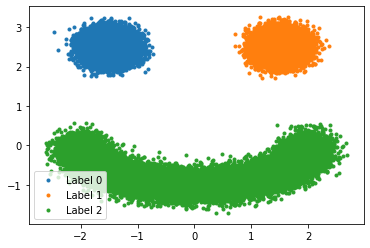

In [45]:
x, y = sample_data_3()
n_samples = x.shape[0]
idx = np.random.permutation(n_samples)
train_size = int(n_samples * 0.8)
x_train = x[idx[:train_size]]
y_train = y[idx[:train_size]]

x_test = x[idx[train_size:]]
y_test = x[idx[train_size:]]
test_size = x_test.shape[0]

plt.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], marker='.', label='Label 0')
plt.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], marker='.', label='Label 1')
plt.scatter(x_train[y_train == 2, 0], x_train[y_train == 2, 1], marker='.', label='Label 2')
plt.legend(loc="lower left")

In [4]:
class Net(nn.Module):
    
    def __init__(self, n_layers=5, n_features=512):
        super(Net, self).__init__()
        self.n_features = n_features
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        
        self.inlayer = nn.Linear(2, self.n_features)
        for i in range(n_layers - 2):
            self.layers.append(nn.Linear(n_features, self.n_features))
        self.outlayer = nn.Linear(self.n_features, 4)
            
    def forward(self, x):
        x = torch.relu(self.inlayer(x))
        for layer in self.layers:
            x = torch.relu(layer(x)) + x # residual connection
        z = self.outlayer(x)
        mu, log_var = torch.split(z, 2, dim=1)
        var = torch.exp(log_var)
        return mu, var

In [72]:
""" Helper functions for training and visualization
"""
    
    
def log_prob(x, mu, var):
    return torch.sum(-0.5 * (torch.log(np.pi * 2 * var) + torch.pow(x - mu, 2) / var), dim=1, keepdim=True)


def train(encoder, decoder, train_data, val_data, n_epoch=50, lr=1e-3, batch_size=125, val_steps=80):
    train_size = train_data.shape[0]
    val_size = val_data.shape[0]
    val_batch = torch.from_numpy(val_data).float().cuda()
    
    n_iter_per_epoch = train_size // batch_size
    
    enc_optim = optim.Adam(encoder.parameters(), lr=lr)
    dec_optim = optim.Adam(decoder.parameters(), lr=lr)
    
    log_kl = {'train':[], 'val': []}
    log_dec = {'train':[], 'val': []}
    log_vlb = {'train':[], 'val': []}

    for i in range(n_epoch):
        idx = np.random.permutation(train_size)
        for j in range(n_iter_per_epoch):
            global_step = i * n_epoch + j + 1
            batch = torch.from_numpy(train_data[idx[j * batch_size : (j + 1) * batch_size]]).float().cuda()

            mu_z, var_z = encoder(batch)

            epsilon = torch.randn(batch.shape).cuda()
            sampled_z = mu_z + epsilon * torch.sqrt(var_z)

            mu_x, var_x = decoder(sampled_z)

            nll = -torch.sum(log_prob(batch, mu_x, var_x), dim=1, keepdim=True)

            kl_div = 1.0 + torch.log(var_z) - torch.pow(mu_z, 2) - var_z
            kl_div = -0.5 * torch.sum(kl_div, dim=1, keepdim=True)

            loss = torch.mean(nll + kl_div)

            enc_optim.zero_grad()
            dec_optim.zero_grad()
            loss.backward()
            # Gradient Clipping
            utils.clip_grad_norm_(encoder.parameters(), 1.0)
            utils.clip_grad_norm_(decoder.parameters(), 1.0)
            
            enc_optim.step()
            dec_optim.step()

            log_dec['train'].append(torch.mean(nll).detach().item() / 2.0)
            log_kl['train'].append(torch.mean(kl_div).detach().item())
            log_vlb['train'].append(torch.mean(-loss).detach().item())
#             print("Epoch-{:d}/{:d} Iteration-{:d}/{:d} Loss-{:.5f}".format(i + 1, n_epoch, j + 1, n_iter_per_epoch, loss.item()))
            
            if global_step % val_steps == 0:
                with torch.no_grad():
                    mu_z, var_z = encoder(val_batch)
                    epsilon = torch.randn(val_batch.shape).cuda()
                    sampled_z = mu_z + epsilon * torch.sqrt(var_z)
                    mu_x, var_x = decoder(sampled_z)
                    val_nll = -torch.sum(log_prob(val_batch, mu_x, var_x), dim=1, keepdim=True)
                    val_kl = 1.0 + torch.log(var_z) - torch.pow(mu_z, 2) - var_z
                    val_kl = -0.5 * torch.sum(val_kl, dim=1, keepdim=True)
                    log_dec['val'].append(torch.mean(val_nll).detach().item() / 2.0)
                    log_kl['val'].append(torch.mean(val_kl).detach().item())
                    log_vlb['val'].append(torch.mean(-val_nll - val_kl).detach().item())
    return log_vlb, log_kl, log_dec


def visualize_curves(log_vlb, log_kl, log_dec, val_steps=80):
    gs = gridspec.GridSpec(2, 2)

    fig = plt.figure(figsize=(10, 10))

    ax = plt.subplot(gs[0])
    l = len(log_vlb['train'])
    ax.plot(np.arange(1, l + 1), log_vlb['train'], label='train')
    l = len(log_vlb['val'])
    ax.plot(np.arange(1, l + 1) * val_steps, log_vlb['val'], label='val')
    ax.set_xlabel("Iterations")
    ax.set_title("VLB")
    ax.legend(loc="lower right")

    ax = plt.subplot(gs[1])
    l = len(log_kl['train'])
    ax.plot(np.arange(1, l + 1), log_kl['train'], label='train')
    l = len(log_kl['val'])
    ax.plot(np.arange(1, l + 1) * val_steps, log_kl['val'], label='val')
    ax.set_xlabel("Iterations")
    ax.set_title("KL-divergence")
    ax.legend(loc="lower right")
    
    ax = plt.subplot(gs[2])
    l = len(log_dec['train'])
    ax.plot(np.arange(1, l + 1), log_dec['train'], label='train')
    l = len(log_dec['val'])
    ax.plot(np.arange(1, l + 1) * val_steps, log_dec['val'], label='val')
    ax.set_xlabel("Iterations")
    ax.set_ylabel("bits/dim")
    ax.set_title("Decoder term")
    ax.legend(loc="lower right")
    
    
def sample(decoder, n_samples=100000):
    z = torch.randn([n_samples, 2]).cuda()
    mu_x, var_x = decoder(z)
    noisy_x = torch.randn([n_samples, 2]).cuda() * torch.sqrt(var_x) + mu_x
    return noisy_x, mu_x


def visualize_samples(noisy_x, mu_x):
    noisy_x = noisy_x.cpu().data.numpy()
    mu_x = mu_x.cpu().data.numpy()
    
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 2)

    ax = plt.subplot(gs[0])
    ax.scatter(noisy_x[:, 0], noisy_x[:, 1], marker='.')
    ax.set_title("Samples from the full generation path")

    ax = plt.subplot(gs[1])
    ax.scatter(mu_x[:, 0], mu_x[:, 1], marker='.')
    ax.set_title("Samples without decoder noise")
    
    ax = plt.subplot(gs[2])
    ax.scatter(noisy_x[:, 0], noisy_x[:, 1], marker='.', label='Full path')
    ax.scatter(mu_x[:, 0], mu_x[:, 1], marker='.', label='Mean')
    ax.set_title("Put together")
    ax.legend(loc="lower left")

In [73]:
encoder = Net(n_layers=3, n_features=512).cuda()
decoder = Net(n_layers=3, n_features=512).cuda()

log_vlb, log_kl, log_dec = train(encoder, decoder, x_train, x_test,
                                                   n_epoch=10000, lr=2e-4, batch_size=10000, val_steps=4)

## Curves

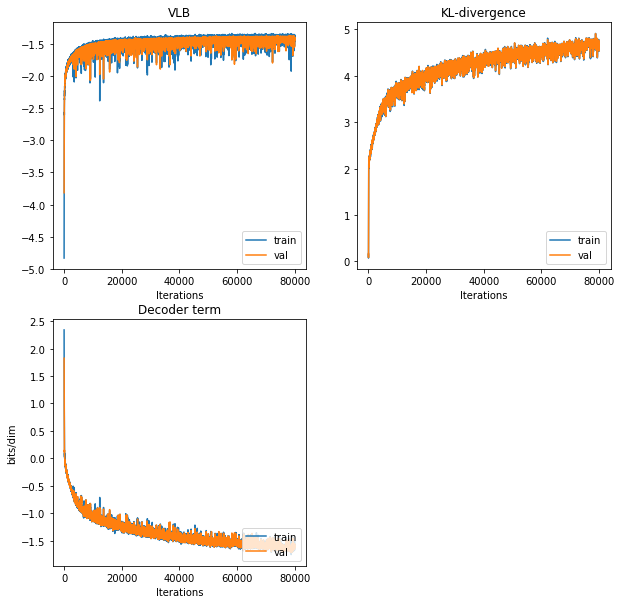

In [74]:
visualize_curves(log_vlb, log_kl, log_dec, val_steps=4)

## Samples

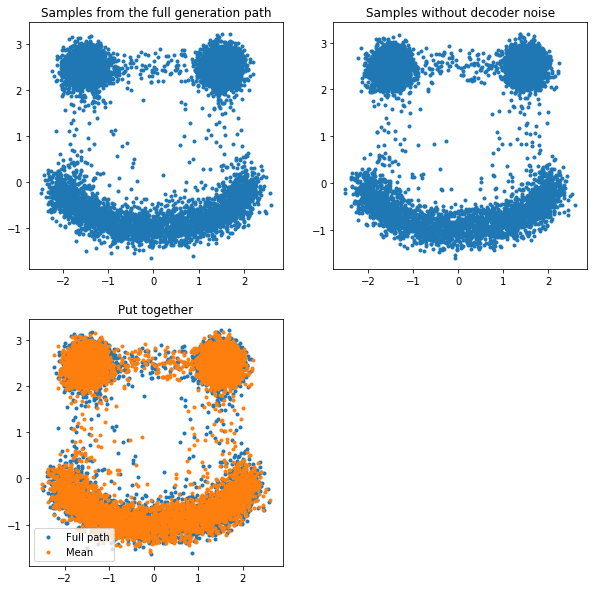

In [173]:
noisy_x, mu_x = sample(decoder, 10000)
visualize_samples(noisy_x, mu_x)

## Latents for data

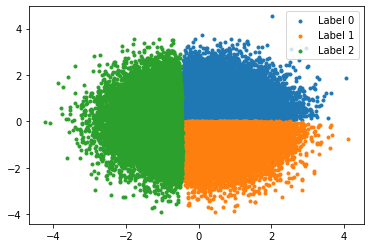

In [78]:
mu_z, var_z = encoder(torch.from_numpy(x_train).float().cuda())
sampled_z = torch.randn(x_train.shape).float().cuda() * torch.sqrt(var_z) + mu_z
z_np = sampled_z.cpu().data.numpy()
plt.scatter(z_np[y_train == 0, 0], z_np[y_train == 0, 1], marker='.', label='Label 0')
plt.scatter(z_np[y_train == 1, 0], z_np[y_train == 1, 1], marker='.', label='Label 1')
plt.scatter(z_np[y_train == 2, 0], z_np[y_train == 2, 1], marker='.', label='Label 2')
plt.legend()

## IWAE Objective Calculation
Note that we can not seperate the ELBO into sum of a decoder term and a regularization term ($D_{KL}[q(z|x)||p(z)]$) according to the IWAE paper.

In [166]:
def get_prob(x, mu, var):
    with torch.no_grad():
        prob =  torch.exp(-0.5 * torch.pow(x - mu, 2) / var) / torch.sqrt(np.pi * 2 * var)
        return prob[:, :, 0:1] * prob[:, :, 1:]


def get_iwae_obj(x, k=100):
    with torch.no_grad():
        mu_z, var_z = encoder(x)
        mu_z = torch.unsqueeze(mu_z, dim=0)
        var_z = torch.unsqueeze(var_z, dim=0)
        sampled_z = torch.randn([k, x.shape[0], x.shape[1]]).cuda() * torch.sqrt(var_z) + mu_z
        mu_x, var_x = decoder(sampled_z.view([-1, 2]))
        mu_x = mu_x.view(sampled_z.shape)
        var_x = var_x.view(sampled_z.shape)

        p_x_z = get_prob(x, mu_x, var_x)
        p_z = get_prob(sampled_z, torch.zeros_like(mu_z).cuda(), torch.ones_like(var_z).cuda())
        q_z_x = get_prob(sampled_z, mu_z, var_z)

        w = torch.mean((p_x_z * p_z) / q_z_x, dim=0)
        iwae_obj = torch.mean(torch.log(w))
        return iwae_obj

In [167]:
x = torch.from_numpy(x_test[:100]).float().cuda()
elbo = get_iwae_obj(x, 1)
print("ELBO: {:.5f}".format(elbo.item()))
iwae_obj = get_iwae_obj(x, 100)
print("IWAE-obj: {:.5f}".format(iwae_obj.item()))

ELBO: -1.39989
IWAE-obj: -1.38112
